# 0. Imports and Dataset

In [2]:
# %pip install flax
# %pip install optax
# %pip install tqdm
# %pip install jax-tqdm
# %pip install bayesian-optimization

In [3]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from jax.flatten_util import ravel_pytree
import torchvision
import optax

from jax.scipy.signal import convolve2d
from jax.lax import scan

In [5]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
images = np.array(mnist_train.data) / 255.0
labels = mnist_train.targets

mnist_test = torchvision.datasets.MNIST(root='./data', train=False)
images_test = np.array(mnist_test.data) / 255.0
labels_test = mnist_test.targets

train = (images, labels)
test = (images_test, labels_test)

# 1. Mask Generation

## 1.1 Example

We show an example of applying the mask-generation pipeline described in the paper.

In [6]:
key = jr.PRNGKey(0)
mask_example = jr.randint(key, (28, 28), minval=0, maxval=2).astype(float)

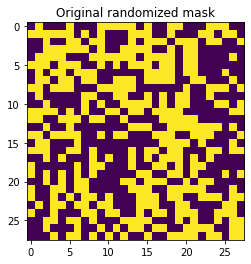

In [7]:
fig, ax = plt.subplots()
ax.imshow(mask_example);
ax.set_title('Original randomized mask');

In [8]:
def blur_filter(image, filter=(1/4, 1/2, 1/4), n_iter=5):
    filter = jnp.array(filter)

    def _apply_filter(image, _):
        # Horizontal filter
        blurred_image = convolve2d(image, filter.reshape(-1, 1), mode='same')

        # Vertical filter
        blurred_image = convolve2d(blurred_image, filter.reshape(1, -1), mode='same')

        return (blurred_image), (blurred_image)
    
    blurred_image, _ = scan(_apply_filter, image, jnp.arange(n_iter))

    return blurred_image

apply_threshold = lambda arr: jnp.where(arr >= 0.5, 1.0, 0.0)

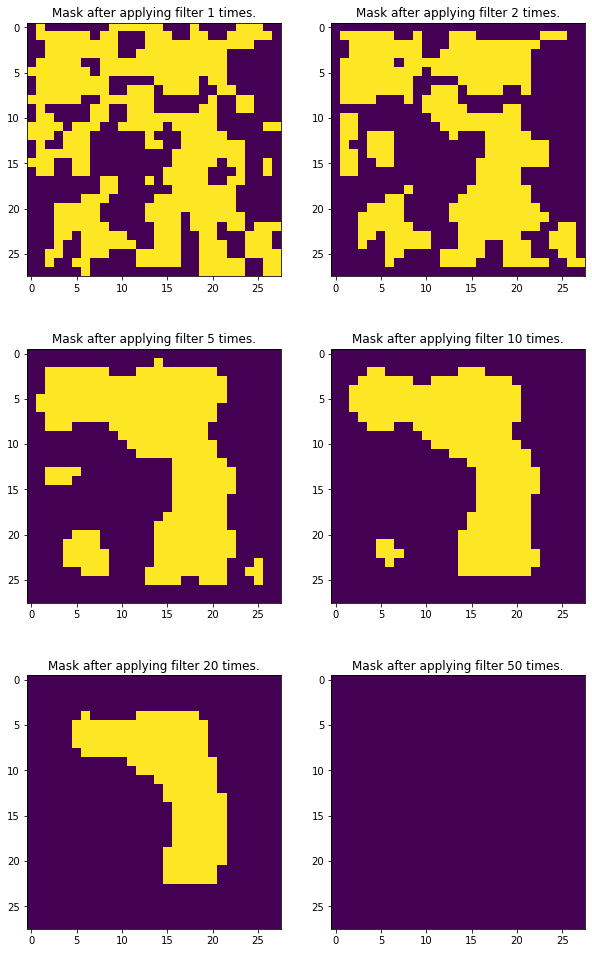

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(10, 17))
n_iter_list = (1, 2, 5, 10, 20, 50)

for i, n_iter in enumerate(n_iter_list):
    curr_ax = axes[i//2, i%2]
    blurred_image = apply_threshold(blur_filter(mask_example, n_iter=n_iter))
    curr_ax.imshow(blurred_image)
    curr_ax.set_title(f'Mask after applying filter {n_iter} times.');

Using this mask (after applying filter 5 times) we can generate a hybrid image used as negative data.

In [10]:
blurred_image = apply_threshold(blur_filter(mask_example, n_iter=5))
neg_blurred_image = 1-blurred_image

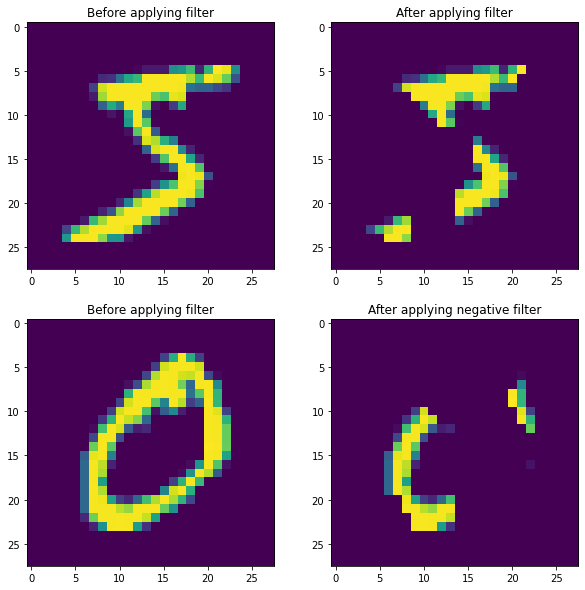

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0,0].imshow(images[0]);
axes[0,0].set_title('Before applying filter');
axes[1,0].imshow(images[1]);
axes[1,0].set_title('Before applying filter');

axes[0,1].imshow(images[0]*blurred_image);
axes[0,1].set_title('After applying filter');
axes[1,1].imshow(images[1]*neg_blurred_image);
axes[1,1].set_title('After applying negative filter');

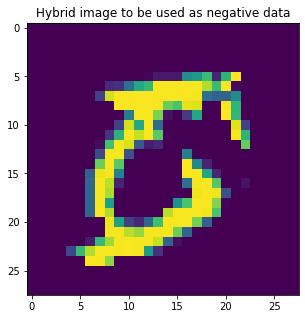

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(images[0]*blurred_image + images[1]*neg_blurred_image);
ax.set_title('Hybrid image to be used as negative data');

## 1.2 Mask Generation Pipeline

# 2. MLP Model

In [14]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        x = nn.Dense(2_000)(x)
        x = self.activation(x)
        x = nn.Dense(2_000)(x)
        x = self.activation(x)
        x = nn.Dense(2_000)(x)
        x = self.activation(x)
        x = nn.Dense(2_000)(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
key = jr.PRNGKey(1)
dim_out = 1
dim_in = (28, 28, 1)
model = MLP(dim_out, activation=nn.relu)
params = model.init(key, jnp.ones((1, *dim_in)))
flat_params, unflatten_fn = ravel_pytree(params)
n_params = len(flat_params)
print(f'flat_params.shape: {flat_params.shape}')

# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

mlp_apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

flat_params.shape: (13578001,)
